# Highway classifier - Gabbar

## Step 1. Prepare problem

#### 1a. Load libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = [
    'changeset_id', 'changeset_harmful', 'feature_id',
#     'feature_version',
#     'action_create', 'action_modify', 'action_delete',
#     'geometry_type_node', 'geometry_type_way', 'geometry_type_relation',
#     'geometry_line_distance', 'geometry_kinks', 
#     'old_user_mapping_days', 'new_user_mapping_days',
    'new_tags', 'old_tags'
]

## Labelled dataset

In [7]:
labelled_path = '../downloads/highway-classifier/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.head()

(2732, 16)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags
2024,47069264,0,4748048048,2,0,1,0,1,0,0,0.00,0,11,11,NaN,{operator=SPTrans}
2311,46527869,0,62794308,3,0,1,0,1,0,0,0.00,0,187,579,NaN,{highway=turning_loop}
1585,47361809,0,23651285,6,0,1,0,0,1,0,0.16,0,1281,10,NaN,{surface=asphalt}
2166,46892332,0,45105818,6,0,1,0,0,1,0,0.03,0,1,606,{highway=footway},{highway=cycleway}
1323,47419169,0,73058399,18,0,1,0,0,1,0,0.25,0,477,1498,NaN,{surface=asphalt}


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (2732, 16)
Shape after dropping duplicates: (2732, 16)


In [10]:
# Fill null values in tags with empty string.
labelled['old_tags'] = labelled['old_tags'].fillna('')
labelled['new_tags'] = labelled['new_tags'].fillna('')

In [11]:
# Distribution of good and harmful changesets?
labelled.groupby('changeset_harmful').size()

changeset_harmful
0    2655
1      77
dtype: int64

In [12]:
total = labelled.shape[0]

# 70% of the dataset will be used for training.
training = labelled.iloc[0:round(0.7 * total)]
training = training.reset_index(drop=True)
print('Training: {}'.format(training.shape))

# 30% of the dataset will be used for validation.
validation = labelled.iloc[round(0.7 * total):]
validation = validation.reset_index(drop=True)
print('Validation: {}'.format(validation.shape))

Training: (1912, 16)
Validation: (820, 16)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

#### new_tags

In [14]:
new_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

# NOTE: Training vectorizer only on harmful changesets.
new_vectorizer.fit(training[training['changeset_harmful'] == 1]['new_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [15]:
# Looking at some feature names.
print('Number of vectors in new: {}'.format(len(new_vectorizer.get_feature_names())))
new_vectorizer.get_feature_names()

Number of vectors in new: 51


['barrier=yes',
 'bicycle=no',
 'bicycle=yes',
 'bridge=yes',
 'construction=motorway',
 'foot=yes',
 'footway=sidewalk',
 'highway=coastline',
 'highway=footway',
 'highway=living_street',
 'highway=primary',
 'highway=residential',
 'highway=road',
 'highway=secondary',
 'highway=service',
 'highway=track',
 'highway=unclassified',
 'horse=no',
 'horse=yes',
 'landuse=footway',
 'landuse=forest',
 'landuse=grass',
 'landuse=recreation_ground',
 'landuse_1=park',
 'landuse_1=recreation_ground',
 'landuse_2=festival area',
 'landuse_3=dog park',
 'landuse_3=recreation',
 'landuse_4=recreation_ground',
 'landuse_5=water_park',
 'layer=1',
 'leisure=park',
 'lit=yes',
 'maxspeed=8',
 'natural=footway',
 'natural=tree_row',
 'noname=yes',
 'oneway=no',
 'oneway=yes',
 'surface=asphalt',
 'surface=grass',
 'surface=gravel',
 'surface=unpaved',
 'surface_1=asphalt',
 'surface_1=ground',
 'surface_2=unpaved',
 'surface_2=wood',
 'tracktype=grade3',
 'waterway=canal',
 'waterway=river',
 'wat

In [16]:
# Convert to a Pandas DataFrame to make merging easier.
new_vectorized = pd.DataFrame(
    new_vectorizer.transform(training['new_tags']).toarray(),
    columns=new_vectorizer.get_feature_names()
)

# Add "new" prefix to column names.
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]
new_vectorized.head()

,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_surface=asphalt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### old_tags

In [17]:
old_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

old_vectorizer.fit(training[training['changeset_harmful'] == 1]['old_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [18]:
# Looking at some feature names.
print('Number of vectors in old: {}'.format(len(old_vectorizer.get_feature_names())))
old_vectorizer.get_feature_names()

Number of vectors in old: 15


['construction=path',
 'embankment=yes',
 'highway=construction',
 'highway=footway',
 'highway=pedestrian',
 'highway=primary',
 'highway=residential',
 'highway=service',
 'highway=tertiary',
 'highway=unclassified',
 'lit=no',
 'maxspeed=30',
 'natural=coastline',
 'oneway=yes',
 'width=0']

In [19]:
# Convert to a Pandas DataFrame to make merging easier.
old_vectorized = pd.DataFrame(
    old_vectorizer.transform(training['old_tags']).toarray(),
    columns=old_vectorizer.get_feature_names()
)

# Add "old" prefix to column names.
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]
old_vectorized.head()

,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_width=0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model training

In [20]:
# Concatenate both initial training data and vectorized data.
training = pd.concat([training, new_vectorized, old_vectorized], axis=1)
print(training.shape)
training.head()

(1912, 82)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_surface=asphalt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_width=0
0,47069264,0,4748048048,2,0,1,0,1,0,0,0.00,0,11,11,,{operator=SPTrans},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,46527869,0,62794308,3,0,1,0,1,0,0,0.00,0,187,579,,{highway=turning_loop},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,47361809,0,23651285,6,0,1,0,0,1,0,0.16,0,1281,10,,{surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46892332,0,45105818,6,0,1,0,0,1,0,0.03,0,1,606,{highway=footway},{highway=cycleway},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,47419169,0,73058399,18,0,1,0,0,1,0,0.25,0,477,1498,,{surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
training.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_surface=asphalt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_width=0
count,1.91e+03,1912.00,1.91e+03,1912.00,1.91e+03,1912.00,1912.0,1912.00,1912.00,1.91e+03,1912.00,1912.00,1912.00,1912.00,1.91e+03,1.91e+03,1912.00,1.91e+03,1.91e+03,1912.00,1.91e+03,1.91e+03,1912.00,1.91e+03,1.91e+03,1912.00,1.91e+03,1.91e+03,1912.00,1.91e+03,1912.00,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1912.00,1912.00,1912.00,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1912.00,1912.00,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03,1.91e+03
mean,4.73e+07,0.03,2.97e+08,5.74,2.62e-03,1.00,0.0,0.06,0.94,2.62e-03,1.05,0.10,644.90,295.19,1.05e-03,6.28e-03,0.01,2.09e-03,1.57e-03,0.02,2.09e-03,5.23e-04,0.02,2.62e-03,2.62e-03,0.01,2.62e-03,5.23e-03,0.01,4.71e-03,0.01,4.18e-03,3.66e-03,5.23e-04,2.09e-03,1.05e-03,1.05e-03,5.23e-04,5.23e-04,1.05e-03,5.23e-04,5.23e-04,5.23e-04,5.23e-04,9.94e-03,1.57e-03,2.62e-03,5.23e-04,5.23e-04,5.23e-04,3.66e-03,0.01,0.03,0.39,5.23e-04,1.57e-03,4.71e-03,5.23e-04,5.23e-04,5.23e-04,5.23e-04,5.23e-04,5.23e-04,1.05e-03,5.23e-04,5.23e-04,5.23e-04,3.66e-03,8.37e-03,4.71e-03,4.71e-03,0.02,0.01,8.89e-03,6.80e-03,5.23e-04,1.57e-03,5.23e-04,7.85e-03,5.23e-04
std,7.32e+05,0.17,6.36e+08,4.88,5.11e-02,0.05,0.0,0.23,0.24,5.11e-02,7.16,1.97,716.29,517.42,3.23e-02,7.90e-02,0.11,4.57e-02,3.96e-02,0.13,4.57e-02,2.29e-02,0.15,5.11e-02,5.11e-02,0.11,5.11e-02,7.21e-02,0.10,6.85e-02,0.11,6.46e-02,6.04e-02,2.29e-02,4.57e-02,3.23e-02,3.23e-02,2.29e-02,2.29e-02,3.23e-02,2.29e-02,2.29e-02,2.29e-02,2.29e-02,9.92e-02,3.96e-02,5.11e-02,2.29e-02,2.29e-02,2.29e-02,6.04e-02,0.10,0.18,0.49,2.29e-02,3.96e-02,6.85e-02,2.29e-02,2.29e-02,2.29e-02,2.29e-02,2.29e-02,2.29e-02,3.23e-02,2.29e-02,2.29e-02,2.29e-02,6.04e-02,9.11e-02,6.85e-02,6.85e-02,0.13,0.10,9.39e-02,8.22e-02,2.29e-02,3.96e-02,2.29e-02,8.82e-02,2.29e-02
min,4.48e+07,0.00,1.73e+05,2.00,0.00e+00,0.00,0.0,0.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+0

In [22]:
# Add good way to check if all properties are ok.
training.sum()

changeset_id                                                       90395412084
changeset_harmful                                                           57
feature_id                                                        568094550591
feature_version                                                          10966
action_create                                                                5
action_modify                                                             1907
action_delete                                                                0
geometry_type_node                                                         108
geometry_type_way                                                         1799
geometry_type_relation                                                       5
geometry_line_distance                                                   2e+03
geometry_kinks                                                             184
old_user_mapping_days                               

In [23]:
X = training.drop(non_training_attributes, axis=1)
y = training['changeset_harmful']

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1,  0.5],
    'max_features': ['log2'],
    'random_state': [random_state],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['log2'], 'random_state': [5], 'n_estimators': [300, 500, 700], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [26]:
print('Best score: {}'.format(grid.best_score_))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.9712343096234309
Best params: {'max_features': 'log2', 'random_state': 5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}


In [27]:
# Set model to the best estimator.
model = grid.best_estimator_

# What attributes are important?
importances = pd.DataFrame(
    list(zip(X.columns, model.feature_importances_)),
    columns=['feature', 'importance']
)
importances.sort(columns='importance', ascending=False).head(10)

,feature,importance
10,new_user_mapping_days,0.12
7,geometry_line_distance,0.11
9,old_user_mapping_days,0.11
0,feature_version,0.09
31,new_landuse=forest,0.03
8,geometry_kinks,0.03
26,new_highway=track,0.03
45,new_natural=footway,0.02
63,old_embankment=yes,0.02
68,old_highway=residential,0.02


In [28]:
training['prediction'] = model.predict(X)
training.to_csv(labelled_path + 'training-review.csv', index=False)

In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y, training['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,1855,0
Labelled harmful,14,43


In [30]:
from sklearn.metrics import classification_report

report = classification_report(y, training['prediction'])
print(report)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1855
          1       1.00      0.75      0.86        57

avg / total       0.99      0.99      0.99      1912



In [31]:
scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
print('Precision on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
print('Recall on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print('F1 score on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

Precision on training: 0.46 (0.42)
Recall on training: 0.19 (0.18)
F1 score on training: 0.27 (0.24)


In [32]:
train_sizes = np.linspace(0.1, 1.0, 5)
training_sizes, training_scores, validation_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=cv, scoring='f1')

In [33]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_tscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_tscores

,training_score,validation_score
0.10,1.00,0.03
0.33,1.00,0.15
0.55,1.00,0.13
0.78,0.91,0.20
1.00,0.87,0.27


## Model validation

In [34]:
validation.groupby('changeset_harmful').size()

changeset_harmful
0    800
1     20
dtype: int64

In [35]:
# Distribution of good and harmful changesets?
validation.groupby('changeset_harmful').size()

changeset_harmful
0    800
1     20
dtype: int64

In [36]:
# Vectorize old_tags.
old_vectorized = pd.DataFrame(old_vectorizer.transform(validation['old_tags']).toarray(), columns=old_vectorizer.get_feature_names())
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]

# Vectorize new_tags.
new_vectorized = pd.DataFrame(new_vectorizer.transform(validation['new_tags']).toarray(), columns=new_vectorizer.get_feature_names())
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]

In [37]:
# Concatenate both initial validation data and vectorized data.
validation = pd.concat([validation, new_vectorized, old_vectorized], axis=1)
print(validation.shape)
validation.head()

(820, 82)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_surface=asphalt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_width=0
0,47510889,0,8407754,15,0,1,0,0,1,0,0.39,0,259,148,,{surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47583790,0,11579496,4,0,1,0,0,1,0,0.78,0,1222,0,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,47025923,0,77090726,3,0,1,0,0,1,0,0.54,0,682,3,,{horse=no},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,47606851,0,111757647,2,0,1,0,0,1,0,0.06,0,157,0,{highway=cycleway},{highway=footway},0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,48195633,0,376336253,5,0,1,0,0,1,0,0.08,0,2,2,,{lanes=1},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
validation.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_surface=asphalt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_width=0
count,8.20e+02,820.00,8.20e+02,820.00,8.20e+02,820.00,820.0,820.00,820.00,8.20e+02,820.00,820.00,820.00,820.00,8.20e+02,8.20e+02,820.00,8.20e+02,820.0,820.00,8.20e+02,820.0,820.00,820.0,8.20e+02,820.00,820.0,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,8.20e+02,8.20e+02,8.20e+02,820.0,820.0,820.0,8.20e+02,8.20e+02,820.00,820.00,8.20e+02,8.20e+02,8.20e+02,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,820.0,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,8.20e+02,820.0,820.0,820.0,8.20e+02,820.0
mean,4.73e+07,0.02,2.89e+08,6.05,1.22e-03,1.00,0.0,0.06,0.94,1.22e-03,1.54,0.19,690.59,280.81,2.44e-03,4.88e-03,0.02,3.66e-03,0.0,0.02,2.44e-03,0.0,0.02,0.0,4.88e-03,0.01,0.0,1.22e-03,4.88e-03,7.32e-03,2.44e-03,3.66e-03,4.88e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.88e-03,1.22e-03,6.10e-03,0.0,0.0,0.0,3.66e-03,4.88e-03,0.03,0.38,1.22e-03,3.66e-03,4.88e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.22e-03,8.54e-03,4.88e-03,3.66e-03,9.76e-03,7.32e-03,6.10e-03,8.54e-03,0.0,0.0,0.0,7.32e-03,0.0
std,7.15e+05,0.15,6.23e+08,5.52,3.49e-02,0.03,0.0,0.24,0.24,3.49e-02,11.95,5.17,711.40,476.07,4.94e-02,6.97e-02,0.15,6.04e-02,0.0,0.13,4.94e-02,0.0,0.15,0.0,6.97e-02,0.10,0.0,3.49e-02,6.97e-02,8.53e-02,4.94e-02,6.04e-02,6.97e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.97e-02,3.49e-02,7.79e-02,0.0,0.0,0.0,6.04e-02,6.97e-02,0.17,0.49,3.49e-02,6.04e-02,6.97e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.49e-02,9.21e-02,6.97e-02,6.04e-02,9.83e-02,8.53e-02,7.79e-02,9.21e-02,0.0,0.0,0.0,8.53e-02,0.0
min,4.48e+07,0.00,1.98e+05,2.00,0.00e+00,0.00,0.0,0.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.0,0.00,0.00e+00,0.0,0.00,0.0,0.00e+00,0.00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0
25%,4.70e+07,0.00,3.27e+07,3.00,0.00e+00,1.00,0.0,0.00,1.00,0.00e+00,0.05,0.00,124.50,3.00,0.00e+00,0.00e+00,0.00,0.00e+00,0.0,0.00,0.00e+00,0.0,0.00,0.0,0.00e+00,0.00,0.0,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00,0.00,0.00e+

In [39]:
# Add good way to check if all properties are ok.
validation.sum()

changeset_id                                                       38759655198
changeset_harmful                                                           20
feature_id                                                        237177774502
feature_version                                                           4962
action_create                                                                1
action_modify                                                              819
action_delete                                                                0
geometry_type_node                                                          49
geometry_type_way                                                          770
geometry_type_relation                                                       1
geometry_line_distance                                                 1.3e+03
geometry_kinks                                                             158
old_user_mapping_days                               

In [40]:
vX = validation.drop(non_training_attributes, axis=1)
vy = validation['changeset_harmful']

In [41]:
validation['prediction'] = model.predict(vX)
validation.to_csv(labelled_path + 'validation-review.csv', index=False)

In [42]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(vy, validation['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,797,3
Labelled harmful,19,1


In [43]:
from sklearn.metrics import classification_report

report = classification_report(vy, validation['prediction'])
print(report)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       800
          1       0.25      0.05      0.08        20

avg / total       0.96      0.97      0.96       820



In [44]:
scores = cross_val_score(model, vX, vy, cv=cv, scoring='precision')
print('Precision on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, vX, vy, cv=cv, scoring='recall')
print('Recall on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, vX, vy, cv=cv, scoring='f1')
print('F1 score on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

Precision on validation: 0.0 (0.0)
Recall on validation: 0.0 (0.0)
F1 score on validation: 0.0 (0.0)


In [45]:
training_sizes, training_scores, validation_scores = learning_curve(
    model, vX, vy, train_sizes=train_sizes, cv=cv, scoring='f1')

In [46]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_vscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_vscores

,training_score,validation_score
0.10,1.00,0.00
0.33,1.00,0.07
0.55,1.00,0.00
0.78,1.00,0.12
1.00,0.93,0.00


## Production model
- Training model on `100%` of the samples.

In [47]:
new_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

# NOTE: Training vectorizer only on harmful changesets.
new_vectorizer.fit(labelled[labelled['changeset_harmful'] == 1]['new_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [48]:
# Looking at some feature names.
print('Number of vectors in new: {}'.format(len(new_vectorizer.get_feature_names())))
new_vectorizer.get_feature_names()

Number of vectors in new: 63


['barrier=yes',
 'bicycle=no',
 'bicycle=yes',
 'bridge=yes',
 'construction=motorway',
 'foot=yes',
 'footway=sidewalk',
 'highway=coastline',
 'highway=footway',
 'highway=living_street',
 'highway=motorway',
 'highway=path',
 'highway=primary',
 'highway=residential',
 'highway=road',
 'highway=secondary',
 'highway=service',
 'highway=tertiary',
 'highway=track',
 'highway=unclassified',
 'horse=no',
 'horse=yes',
 'landuse=cemetery',
 'landuse=footway',
 'landuse=forest',
 'landuse=grass',
 'landuse=recreation_ground',
 'landuse_1=park',
 'landuse_1=recreation_ground',
 'landuse_2=festival area',
 'landuse_3=dog park',
 'landuse_3=recreation',
 'landuse_4=recreation_ground',
 'landuse_5=water_park',
 'lanes=1',
 'lanes=2',
 'layer=1',
 'leisure=park',
 'lit=yes',
 'maxspeed=10 mph',
 'maxspeed=20',
 'maxspeed=50',
 'maxspeed=8',
 'natural=footway',
 'natural=tree_row',
 'noname=yes',
 'oneway=no',
 'oneway=yes',
 'park=yes',
 'surface=asphalt',
 'surface=dirt',
 'surface=grass',
 

In [49]:
# Convert to a Pandas DataFrame to make merging easier.
new_vectorized = pd.DataFrame(
    new_vectorizer.transform(labelled['new_tags']).toarray(),
    columns=new_vectorizer.get_feature_names()
)

# Add "new" prefix to column names.
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]
new_vectorized.head()

,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
old_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

old_vectorizer.fit(labelled[labelled['changeset_harmful'] == 1]['old_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [51]:
# Looking at some feature names.
print('Number of vectors in old: {}'.format(len(old_vectorizer.get_feature_names())))
old_vectorizer.get_feature_names()

Number of vectors in old: 17


['construction=path',
 'embankment=yes',
 'highway=construction',
 'highway=footway',
 'highway=path',
 'highway=pedestrian',
 'highway=primary',
 'highway=residential',
 'highway=service',
 'highway=tertiary',
 'highway=unclassified',
 'lit=no',
 'maxspeed=30',
 'natural=coastline',
 'oneway=yes',
 'park=paseo',
 'width=0']

In [52]:
# Convert to a Pandas DataFrame to make merging easier.
old_vectorized = pd.DataFrame(
    old_vectorizer.transform(labelled['old_tags']).toarray(),
    columns=old_vectorizer.get_feature_names()
)

# Add "old" prefix to column names.
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]
old_vectorized.head()

,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# Concatenate both initial training data and vectorized data.
labelled = pd.concat([labelled, new_vectorized, old_vectorized], axis=1)
print(labelled.shape)
labelled.head()

(2732, 96)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
0,49685016,0,500704692,3,0,1,0,0,1,0,0.21,0,1009,4,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,49684098,0,501945519,3,0,1,0,0,1,0,0.27,0,11,11,,{lit=yes} {surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49684091,0,138497224,2,0,1,0,0,1,0,0.61,0,299,118,,{destination=Camp Petersville} {destination:st...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,49670591,0,352893567,3,0,1,0,0,1,0,0.29,0,159,14,,{surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,49633151,0,292617978,9,0,1,0,0,1,0,41.34,0,67,67,{highway=unclassified},{highway=tertiary},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
labelled.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
count,2.73e+03,2732.00,2.73e+03,2732.00,2.73e+03,2732.00,2732.0,2732.00,2732.00,2.73e+03,2732.00,2732.00,2732.00,2732.00,2.73e+03,2.73e+03,2732.00,2.73e+03,2.73e+03,2732.00,2.73e+03,2.73e+03,2732.00,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2732.00,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2732.00,2.73e+03,2732.00,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2732.00,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03,2.73e+03
mean,4.73e+07,0.03,2.95e+08,5.83,2.20e-03,1.00,0.0,0.06,0.94,2.20e-03,1.20,0.13,658.61,290.87,1.46e-03,5.86e-03,0.01,2.56e-03,1.10e-03,0.02,2.20e-03,3.66e-04,0.02,1.83e-03,1.10e-03,5.12e-03,3.29e-03,0.01,1.83e-03,4.03e-03,8.78e-03,6.95e-03,5.49e-03,8.78e-03,4.03e-03,4.03e-03,3.66e-04,3.66e-04,1.46e-03,7.32e-04,7.32e-04,3.66e-04,3.66e-04,7.32e-04,3.66e-04,3.66e-04,3.66e-04,3.66e-04,6.59e-03,5.49e-03,8.42e-03,1.46e-03,3.66e-03,7.32e-04,2.20e-03,2.93e-03,3.66e-04,3.66e-04,3.66e-04,3.66e-03,9.15e-03,0.03,3.66e-04,0.39,2.56e-03,7.32e-04,2.20e-03,4.76e-03,3.66e-04,3.66e-04,3.66e-04,3.66e-04,7.32e-04,3.66e-04,3.66e-04,7.32e-04,3.66e-04,3.66e-04,3.66e-04,2.93e-03,8.42e-03,6.95e-03,4.76e-03,4.39e-03,0.02,9.52e-03,8.05e-03,7.32e-03,3.66e-04,1.10e-03,3.66e-04,7.69e-03,3.66e-04,3.66e-04
std,7.27e+05,0.17,6.32e+08,5.08,4.68e-02,0.05,0.0,0.23,0.24,4.68e-02,8.88,3.28,715.00,505.32,3.82e-02,7.63e-02,0.12,5.06e-02,3.31e-02,0.13,4.68e-02,1.91e-02,0.15,4.27e-02,3.31e-02,7.14e-02,5.73e-02,0.11,4.27e-02,6.33e-02,9.33e-02,8.31e-02,7.39e-02,9.33e-02,6.33e-02,6.33e-02,1.91e-02,1.91e-02,3.82e-02,2.71e-02,2.71e-02,1.91e-02,1.91e-02,2.71e-02,1.91e-02,1.91e-02,1.91e-02,1.91e-02,8.09e-02,7.39e-02,9.14e-02,3.82e-02,6.04e-02,2.71e-02,4.68e-02,5.40e-02,1.91e-02,1.91e-02,1.91e-02,6.04e-02,9.52e-02,0.17,1.91e-02,0.49,5.06e-02,2.71e-02,4.68e-02,6.88e-02,1.91e-02,1.91e-02,1.91e-02,1.91

In [55]:
# Add good way to check if all properties are ok.
labelled.sum()

changeset_id                                                      129155067282
changeset_harmful                                                           77
feature_id                                                        805272325093
feature_version                                                          15928
action_create                                                                6
action_modify                                                             2726
action_delete                                                                0
geometry_type_node                                                         157
geometry_type_way                                                         2569
geometry_type_relation                                                       6
geometry_line_distance                                                 3.3e+03
geometry_kinks                                                             342
old_user_mapping_days                               

In [56]:
X = labelled.drop(non_training_attributes, axis=1)
y = labelled['changeset_harmful']

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1,  0.5],
    'max_features': ['log2'],
    'random_state': [random_state],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['log2'], 'random_state': [5], 'n_estimators': [300, 500, 700], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
print('Best score: {}'.format(grid.best_score_))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.968887262079063
Best params: {'max_features': 'log2', 'random_state': 5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [60]:
# Set model to the best estimator.
model = grid.best_estimator_

# What attributes are important?
importances = pd.DataFrame(
    list(zip(X.columns, model.feature_importances_)),
    columns=['feature', 'importance']
)
importances.sort(columns='importance', ascending=False).head(10)

,feature,importance
7,geometry_line_distance,0.18
10,new_user_mapping_days,0.16
9,old_user_mapping_days,0.14
0,feature_version,0.09
8,geometry_kinks,0.06
21,new_highway=motorway,0.03
6,geometry_type_relation,0.02
69,new_tourism=attraction,0.02
60,new_surface=asphalt,0.02
19,new_highway=footway,0.02


In [61]:
labelled['prediction'] = model.predict(X)
labelled.to_csv(labelled_path + 'training-review-all-samples.csv', index=False)

In [62]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y, labelled['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,2655,0
Labelled harmful,64,13


In [63]:
from sklearn.metrics import classification_report

report = classification_report(y, labelled['prediction'])
print(report)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2655
          1       1.00      0.17      0.29        77

avg / total       0.98      0.98      0.97      2732



In [64]:
scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
print('Precision on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
print('Recall on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print('F1 score on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

Precision on all samples: 0.12 (0.299)
Recall on all samples: 0.027 (0.054)
F1 score on all samples: 0.04 (0.084)


In [65]:
training_sizes, training_scores, validation_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=cv, scoring='f1')

In [66]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_lscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_lscores

,training_score,validation_score
0.10,0.61,7.41e-03
0.33,0.48,4.39e-02
0.55,0.38,4.84e-02
0.78,0.35,4.04e-02
1.00,0.31,4.04e-02


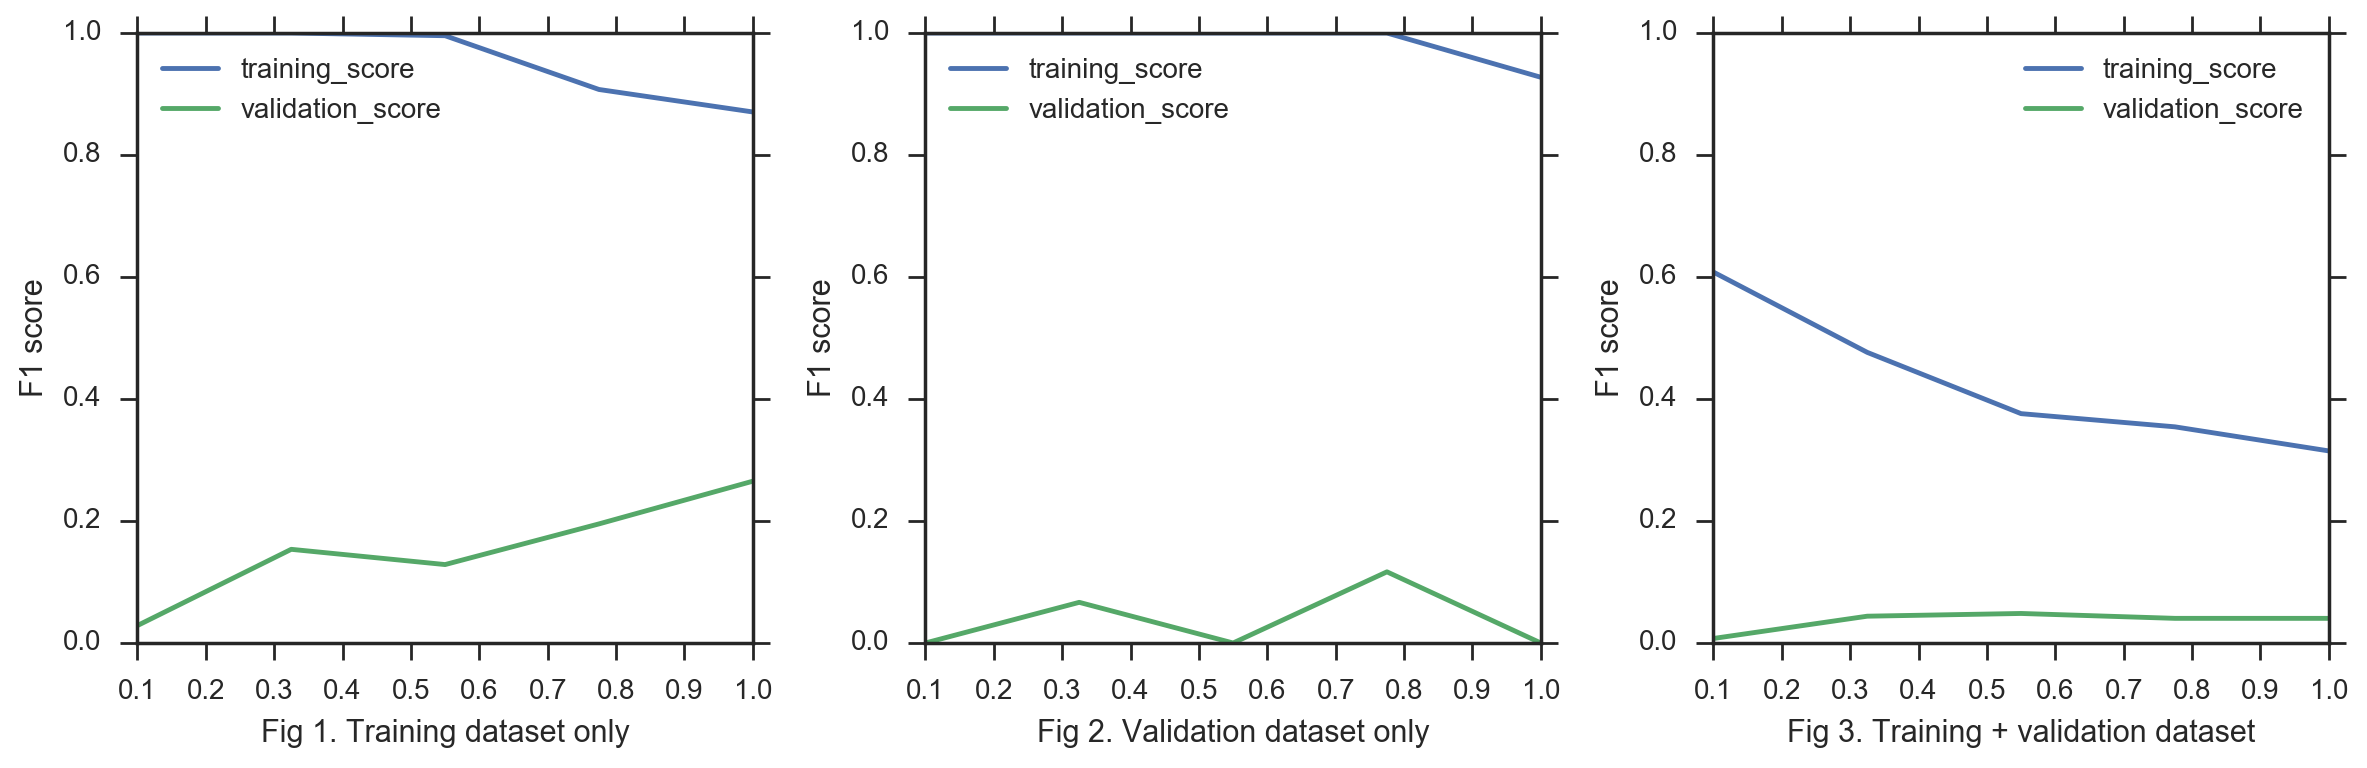

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)

lc_tscores.plot(ax=axes[0])
axes[0].set_ylim([0, 1])
axes[0].set_xlabel('Fig 1. Training dataset only');
axes[0].set_ylabel('F1 score');

lc_vscores.plot(ax=axes[1])
axes[1].set_ylim([0, 1])
axes[1].set_xlabel('Fig 2. Validation dataset only');
axes[1].set_ylabel('F1 score');

lc_lscores.plot(ax=axes[2])
axes[2].set_ylim([0, 1])
axes[2].set_xlabel('Fig 3. Training + validation dataset');
axes[2].set_ylabel('F1 score');

In [68]:
from sklearn.externals import joblib

model_path = '../gabbar/trained/model.pkl'
joblib.dump(model, model_path)

new_vectorizer_path = '../gabbar/trained/new_vectorizer.pkl'
joblib.dump(new_vectorizer, new_vectorizer_path)

old_vectorizer_path = '../gabbar/trained/old_vectorizer.pkl'
joblib.dump(old_vectorizer, old_vectorizer_path)

['../gabbar/trained/old_vectorizer.pkl']

## Model testing

In [69]:
unlabelled_path = testing_path = '../downloads/highway-classifier/unlabelled/'

In [70]:
unlabelled = pd.read_csv(unlabelled_path + 'attributes.csv')
unlabelled.head()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags
0,49180736,NaN,497516862,2,0,1,0,0,1,0,0.03,0,780,780,NaN,{access=no} {foot=permissive} {surface=fine_gr...
1,49180683,NaN,30613789,4,0,1,0,0,1,0,0.04,0,662,1,NaN,{motor_vehicle=permissive}
2,49180666,NaN,477487724,3,0,1,0,0,1,0,0.91,0,837,226,NaN,{oneway=no}
3,49180628,NaN,103763048,11,0,1,0,0,1,0,4.88,0,150,150,NaN,NaN
4,49180608,NaN,4482158804,2,0,1,0,1,0,0,0.00,0,11,11,NaN,{highway=turning_circle}


In [71]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(unlabelled.shape))
unlabelled = unlabelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(unlabelled.shape))

Shape before dropping duplicates: (155, 16)
Shape after dropping duplicates: (155, 16)


In [72]:
# Fill null values in tags with empty string.
unlabelled['old_tags'] = unlabelled['old_tags'].fillna('')
unlabelled['new_tags'] = unlabelled['new_tags'].fillna('')

In [73]:
# Using all of the unlabelled dataset for testing.
testing = unlabelled.sample(unlabelled.shape[0])

In [74]:
# Vectorize old_tags.
old_vectorized = pd.DataFrame(old_vectorizer.transform(testing['old_tags']).toarray(), columns=old_vectorizer.get_feature_names())
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]

# Vectorize new_tags.
new_vectorized = pd.DataFrame(new_vectorizer.transform(testing['new_tags']).toarray(), columns=new_vectorizer.get_feature_names())
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]

In [75]:
# Concatenate both initial validation data and vectorized data.
testing = pd.concat([testing, new_vectorized, old_vectorized], axis=1)
print(testing.shape)
testing.head()

(155, 96)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
0,49180736,NaN,497516862,2,0,1,0,0,1,0,0.03,0,780,780,,{access=no} {foot=permissive} {surface=fine_gr...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,49180683,NaN,30613789,4,0,1,0,0,1,0,0.04,0,662,1,,{motor_vehicle=permissive},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49180666,NaN,477487724,3,0,1,0,0,1,0,0.91,0,837,226,,{oneway=no},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,49180628,NaN,103763048,11,0,1,0,0,1,0,4.88,0,150,150,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,49180608,NaN,4482158804,2,0,1,0,1,0,0,0.00,0,11,11,,{highway=turning_circle},0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [76]:
testing.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
count,1.55e+02,0.0,1.55e+02,155.00,155.00,155.00,155.00,155.0,155.0,155.0,155.00,155.0,155.00,155.00,155.0,1.55e+02,155.0,155.0,155.0,1.55e+02,155.0,155.0,155.00,155.0,155.0,155.00,1.55e+02,155.00,155.0,1.55e+02,155.00,155.0,155.00,155.00,155.00,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.00,155.00,155.0,155.0,155.0,1.55e+02,155.0,1.55e+02,155.0,155.0,155.0,155.0,155.00,155.00,155.0,155.00,155.0,1.55e+02,155.0,1.55e+02,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,1.55e+02,155.0,1.55e+02,1.55e+02,155.00,155.00,155.00,1.55e+02,155.00,155.0,1.55e+02,155.0,155.00,155.0,155.0
mean,4.92e+07,NaN,5.94e+08,4.48,0.03,0.96,0.01,0.1,0.9,0.0,1.26,0.0,418.99,282.27,0.0,6.45e-03,0.0,0.0,0.0,6.45e-03,0.0,0.0,0.01,0.0,0.0,0.01,6.45e-03,0.04,0.0,6.45e-03,0.03,0.0,0.02,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.0,6.45e-03,0.0,6.45e-03,0.0,0.0,0.0,0.0,0.03,0.02,0.0,0.08,0.0,6.45e-03,0.0,6.45e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.45e-03,0.0,6.45e-03,6.45e-03,0.05,0.03,0.02,6.45e-03,0.01,0.0,6.45e-03,0.0,0.01,0.0,0.0
std,1.42e+03,NaN,1.13e+09,3.38,0.16,0.19,0.11,0.3,0.3,0.0,4.67,0.0,565.26,395.08,0.0,8.03e-02,0.0,0.0,0.0,8.03e-02,0.0,0.0,0.11,0.0,0.0,0.11,8.03e-02,0.19,0.0,8.03e-02,0.18,0.0,0.14,0.14,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.14,0.0,0.0,0.0,8.03e-02,0.0,8.03e-02,0.0,0.0,0.0,0.0,0.16,0.14,0.0,0.27,0.0,8.03e-02,0.0,8.03e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.03e-02,0.0,8.03e-02,8.03e-02,0.21,0.18,0.14,8.03e-02,0.11,0.0,8.03e-02,0.0,0.11,0.0,0.0
min,4.92e+07,NaN,4.40e+06,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,1.00,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.0,0.0,0.00,0.00e+00,0.00,0.0,0.00e+00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.00e+00,0.00,0.00,0.00,0.00e+00,0.00,0.0,0.00e+00,0.0,0.00,0.0,0.0
25%,4.92e+07,NaN,1.02e+08,2.00,0.00,1.00,0.00,0.0,1.0,0.0,0.06,0.0,16.00,18.50,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.

In [77]:
# Add good way to check if all properties are ok.
testing.sum()

changeset_id                                                        7622591669
changeset_harmful                                                         None
feature_id                                                         92034629201
feature_version                                                            694
action_create                                                                4
action_modify                                                              149
action_delete                                                                2
geometry_type_node                                                          15
geometry_type_way                                                          140
geometry_type_relation                                                       0
geometry_line_distance                                                   2e+02
geometry_kinks                                                               0
old_user_mapping_days                               

In [78]:
tX = testing.drop(non_training_attributes, axis=1)
ty = testing['changeset_harmful']

In [79]:
testing['prediction'] = model.predict(tX)
testing.to_csv(unlabelled_path + 'testing-review.csv', index=False)

In [80]:
tharmful_count = testing[testing['prediction'] == True].shape[0]
tnot_harmful_count = testing[testing['prediction'] == False].shape[0]

print('Predicted good: {}'.format(tnot_harmful_count))
print('Predicted harmful: {}'.format(tharmful_count))

print('Percentage harmful: {}%'.format(round(100.0 * tharmful_count / testing.shape[0], 2)))

Predicted good: 155
Predicted harmful: 0
Percentage harmful: 0.0%
